# The Baseline Model - Spatial Lag 1 Regression (with lagged features)

Best alpha: 0.00026366508987303583
Test R²: 0.8266494785920374
Test RMSE: 0.0907469270147119

Top Influential Features:
                               Feature  Coefficient  Abs Coef
10                smoothed_wcli_lagged     3.399361  3.399361
11  smoothed_wpublic_transit_1d_lagged    -0.684815  0.684815
1              smoothed_wspent_time_1d    -0.425311  0.425311
12   smoothed_wcovid_vaccinated_lagged    -0.384897  0.384897
3         smoothed_wworried_become_ill     0.365783  0.365783
8         smoothed_wvaccine_likely_who    -0.255827  0.255827
9             smoothed_wlarge_event_1d     0.232119  0.232119
2                 smoothed_wtested_14d    -0.221673  0.221673
5       smoothed_wwork_outside_home_1d     0.206989  0.206989
4                    smoothed_wshop_1d     0.144923  0.144923


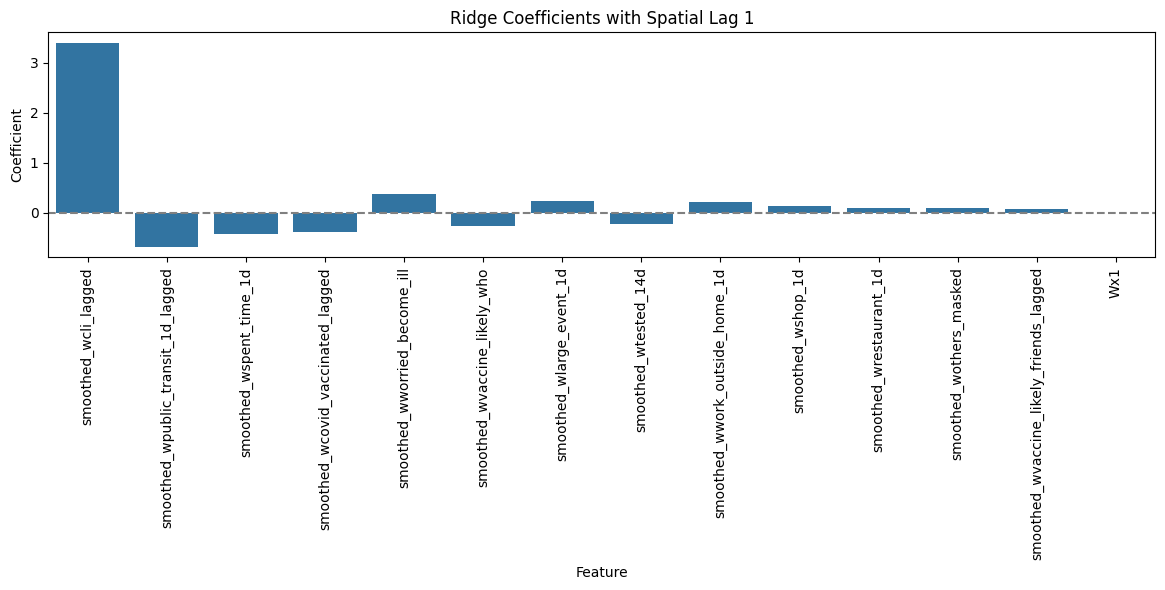

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('merged_fips_moving_average_data.csv')
# Drop one variable from each highly correlated pair
highly_corr_to_drop = [
    "smoothed_wvaccine_likely_govt_health",  # drop in favor of smoothed_wvaccine_likely_who
    "smoothed_wwearing_mask"                 # drop in favor of smoothed_wothers_masked
]

# Drop the columns
data = data.drop(columns=highly_corr_to_drop)

from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# --- Define target and features ---
target_col = "smoothed_wtested_positive_14d"

current_features = [
    'smoothed_wspent_time_1d',
    'smoothed_wtested_14d',       
    'smoothed_wworried_become_ill',
    'smoothed_wshop_1d',
    'smoothed_wwork_outside_home_1d',
    'smoothed_wothers_masked',
    'smoothed_wrestaurant_1d',
    'smoothed_wvaccine_likely_who',
    'smoothed_wlarge_event_1d',  
]

lagged_features_original = [
    'smoothed_wcli',
    'smoothed_wpublic_transit_1d',
    'smoothed_wcovid_vaccinated',
    'smoothed_wvaccine_likely_friends',
]

lagged_features = [
    'smoothed_wcli_lagged',
    'smoothed_wpublic_transit_1d_lagged',
    'smoothed_wcovid_vaccinated_lagged',
    'smoothed_wvaccine_likely_friends_lagged'
]

all_features = current_features + lagged_features

# Parse time_value as datetime
data['time_value'] = pd.to_datetime(data['time_value'])
# Sort chronologically
data = data.sort_values('time_value')

# Row indices for cutoff at 80%, 90%, and 100%
cutoff_80 = int(len(data) * 0.8)
cutoff_90 = int(len(data) * 0.9)
cutoff_100 = len(data)

# Cutoff dates
train_cutoff_date = data.loc[cutoff_80, 'time_value']
validation_cutoff_date = data.loc[cutoff_90, 'time_value']
test_cutoff_date = data.loc[cutoff_100 - 1, 'time_value']

# Temporal split
train_data = data[data['time_value'] < train_cutoff_date]
val_data = data[(data['time_value'] >= train_cutoff_date) & (data['time_value'] < validation_cutoff_date)]
test_data = data[data['time_value'] >= validation_cutoff_date]

# Sort by time and geo_value
train_data_sorted = train_data.sort_values(["geo_value", "time_value"]).reset_index(drop=True)
val_data_sorted = val_data.sort_values(["geo_value", "time_value"]).reset_index(drop=True)
test_data_sorted = test_data.sort_values(["geo_value", "time_value"]).reset_index(drop=True)

# Create lags
def create_lagged_target(df, col, max_lag):
    for lag in range(1, max_lag + 1):
        df[f"{target_col}_lag{lag}"] = (
            df.groupby("geo_value")[target_col]
            .shift(lag)
        )
    return df

train_data_sorted = create_lagged_target(train_data_sorted, target_col, max_lag=2)
val_data_sorted = create_lagged_target(val_data_sorted, target_col, max_lag=2)
test_data_sorted = create_lagged_target(test_data_sorted, target_col, max_lag=2)

# Drop rows with NaN values
train = train_data_sorted.dropna(subset=all_features + [target_col])
val = val_data_sorted.dropna(subset=all_features + [target_col])
test = test_data_sorted.dropna(subset=all_features + [target_col])

# Extract feature matrix and target
X = train[all_features]
y = train[target_col]

# Build a mapping from county to state
county_to_state = train_data_sorted.drop_duplicates("geo_value")[["geo_value", "FIPS State"]]

# Construct W: geo_value × geo_value binary matrix (1 if same state)
geo_values = train_data_sorted["geo_value"].unique()
geo_index = {g: i for i, g in enumerate(geo_values)}
N = len(geo_values)
W = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        if county_to_state.loc[county_to_state["geo_value"] == geo_values[i], "FIPS State"].values[0] == \
           county_to_state.loc[county_to_state["geo_value"] == geo_values[j], "FIPS State"].values[0]:
            W[i, j] = 1

# Row-normalize
W = W / W.sum(axis=1, keepdims=True)

# --- Feature matrix builder with spatial lags ---
def build_matrix_with_spatial_lags_sr1(df, geo_index, W, target_col, current_features, lagged_features):
    X_list = []
    y_list = []

    for date in df["time_value"].unique():
        df_t = df[df["time_value"] == date].copy()
        if df_t.shape[0] < 10:
            print(f"Date {date.date()} skipped, only {df_t.shape[0]} counties")
            continue

        df_t = df_t.set_index("geo_value")
        valid_geo = [g for g in df_t.index if g in geo_index]
        if not valid_geo:
            continue
        idx = [geo_index[g] for g in valid_geo]
        df_t = df_t.loc[valid_geo]

        W_sub = W[np.ix_(idx, idx)]

        # Spatial lag of target (lag1)
        x1 = df_t.loc[valid_geo, f"{target_col}_lag1"].values.reshape(-1, 1)
        Wx1 = W_sub @ x1

        # Feature matrix
        feats = df_t.loc[valid_geo, all_features].values
        X = np.hstack([Wx1, feats])
        y = df_t.loc[valid_geo, target_col].values

        X_list.append(X)
        y_list.append(y)

    if not X_list:
        raise ValueError("No valid time slices with spatial lag could be used.")
    
    return np.vstack(X_list), np.concatenate(y_list)

X_train_sr1, y_train_sr1 = build_matrix_with_spatial_lags_sr1(train_data_sorted, geo_index, W, target_col, current_features, lagged_features)
X_val_sr1, y_val_sr1 = build_matrix_with_spatial_lags_sr1(val_data_sorted, geo_index, W, target_col, current_features, lagged_features)
X_test_sr1, y_test_sr1 = build_matrix_with_spatial_lags_sr1(test_data_sorted, geo_index, W, target_col, current_features, lagged_features)

# Remove any rows with NaNs in training, validation, or test sets
def drop_nan_rows(X, y):
    mask = ~np.isnan(X).any(axis=1)
    return X[mask], y[mask]

X_train_sr1, y_train_sr1 = drop_nan_rows(X_train_sr1, y_train_sr1)
X_val_sr1, y_val_sr1 = drop_nan_rows(X_val_sr1, y_val_sr1)
X_test_sr1, y_test_sr1 = drop_nan_rows(X_test_sr1, y_test_sr1)

# --- Ridge Regression with 5-Fold CV ---
alphas = np.logspace(-4, 4, 20)
ridge_sr1 = RidgeCV(alphas=alphas, cv=KFold(n_splits=5, shuffle=True, random_state=42))
ridge_sr1.fit(X_train_sr1, y_train_sr1)

# --- Evaluation ---
y_pred_sr1 = ridge_sr1.predict(X_test_sr1)
print("Best alpha:", ridge_sr1.alpha_)
print("Test R²:", r2_score(y_test_sr1, y_pred_sr1))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test_sr1, y_pred_sr1)))

# --- Coefficients and Feature Mapping ---
all_feature_names = ['Wx1'] + current_features + lagged_features
coef_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Coefficient": ridge_sr1.coef_,
    "Abs Coef": np.abs(ridge_sr1.coef_)
}).sort_values("Abs Coef", ascending=False)

print("\nTop Influential Features:")
print(coef_df.head(10))

# Plot coefficients ---
plt.figure(figsize=(12, 6))
sns.barplot(data=coef_df, x="Feature", y="Coefficient")
plt.xticks(rotation=90)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Ridge Coefficients with Spatial Lag 1")
plt.tight_layout()
plt.savefig("ridge_coefficients_spatial_lag1.png")
plt.show()

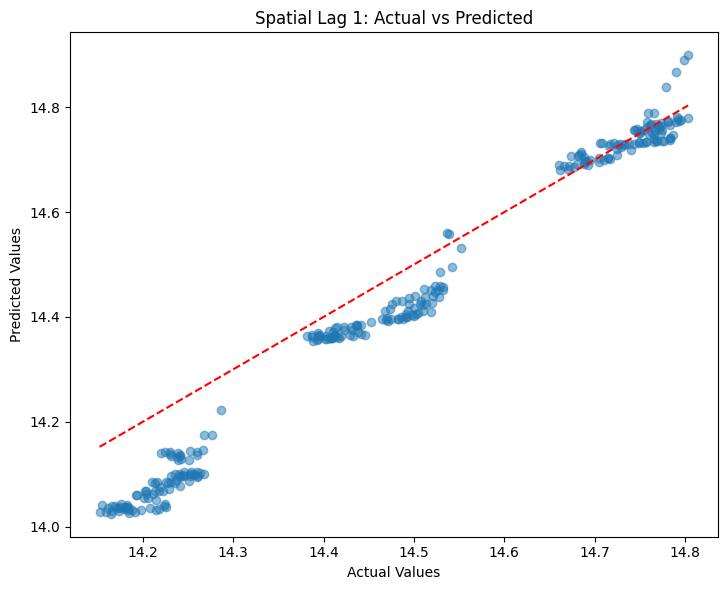

In [5]:
import matplotlib.pyplot as plt

# Plot Actual vs Predicted for Spatial Lag 1
plt.figure(figsize=(14, 6))

# Spatial Lag 1
plt.subplot(1, 2, 1)
plt.scatter(y_test_sr1, y_pred_sr1, alpha=0.5)
plt.plot([y_test_sr1.min(), y_test_sr1.max()], [y_test_sr1.min(), y_test_sr1.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Spatial Lag 1: Actual vs Predicted")
plt.tight_layout()
plt.savefig("actual_vs_predicted_spatial_lag1.png")
plt.show()

# 5-fold

/opt/anaconda3/envs/mlps/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/mlps/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/mlps/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/mlps/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To cal

=== 5-Fold Cross-Validation Results ===
Mean MAE:  0.0236 ± 0.0009
Mean RMSE: 0.0293 ± 0.0009
Mean R²:   0.9995 ± 0.0000

Top Influential Features:
                               Feature  Coefficient  Abs Coef
10                smoothed_wcli_lagged     3.399361  3.399361
11  smoothed_wpublic_transit_1d_lagged    -0.684815  0.684815
1              smoothed_wspent_time_1d    -0.425311  0.425311
12   smoothed_wcovid_vaccinated_lagged    -0.384897  0.384897
3         smoothed_wworried_become_ill     0.365783  0.365783
8         smoothed_wvaccine_likely_who    -0.255827  0.255827
9             smoothed_wlarge_event_1d     0.232119  0.232119
2                 smoothed_wtested_14d    -0.221673  0.221673
5       smoothed_wwork_outside_home_1d     0.206989  0.206989
4                    smoothed_wshop_1d     0.144923  0.144923


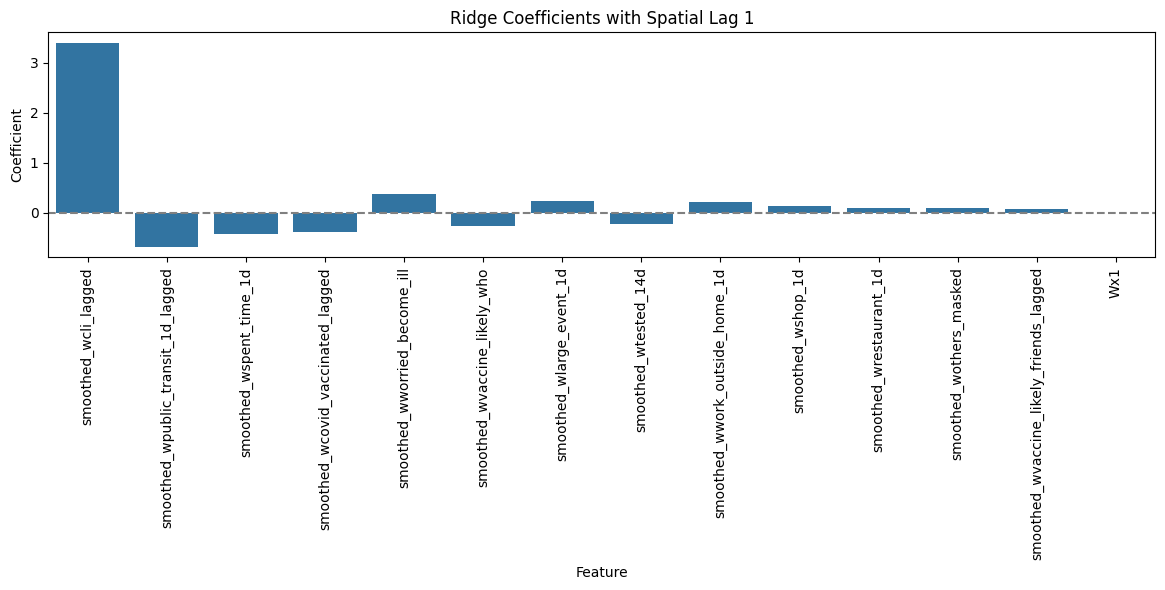

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('merged_fips_moving_average_data.csv')
# Drop one variable from each highly correlated pair
highly_corr_to_drop = [
    "smoothed_wvaccine_likely_govt_health",  # drop in favor of smoothed_wvaccine_likely_who
    "smoothed_wwearing_mask"                 # drop in favor of smoothed_wothers_masked
]

# Drop the columns
data = data.drop(columns=highly_corr_to_drop)

from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# --- Define target and features ---
target_col = "smoothed_wtested_positive_14d"

current_features = [
    'smoothed_wspent_time_1d',
    'smoothed_wtested_14d',       
    'smoothed_wworried_become_ill',
    'smoothed_wshop_1d',
    'smoothed_wwork_outside_home_1d',
    'smoothed_wothers_masked',
    'smoothed_wrestaurant_1d',
    'smoothed_wvaccine_likely_who',
    'smoothed_wlarge_event_1d',  
]

lagged_features_original = [
    'smoothed_wcli',
    'smoothed_wpublic_transit_1d',
    'smoothed_wcovid_vaccinated',
    'smoothed_wvaccine_likely_friends',
]

lagged_features = [
    'smoothed_wcli_lagged',
    'smoothed_wpublic_transit_1d_lagged',
    'smoothed_wcovid_vaccinated_lagged',
    'smoothed_wvaccine_likely_friends_lagged'
]

all_features = current_features + lagged_features

# Parse time_value as datetime
data['time_value'] = pd.to_datetime(data['time_value'])
# Sort chronologically
data = data.sort_values('time_value')

# Row indices for cutoff at 80%, 90%, and 100%
cutoff_80 = int(len(data) * 0.8)
cutoff_90 = int(len(data) * 0.9)
cutoff_100 = len(data)

# Cutoff dates
train_cutoff_date = data.loc[cutoff_80, 'time_value']
validation_cutoff_date = data.loc[cutoff_90, 'time_value']
test_cutoff_date = data.loc[cutoff_100 - 1, 'time_value']

# Temporal split
train_data = data[data['time_value'] < train_cutoff_date]
val_data = data[(data['time_value'] >= train_cutoff_date) & (data['time_value'] < validation_cutoff_date)]
test_data = data[data['time_value'] >= validation_cutoff_date]

# Sort by time and geo_value
train_data_sorted = train_data.sort_values(["geo_value", "time_value"]).reset_index(drop=True)
val_data_sorted = val_data.sort_values(["geo_value", "time_value"]).reset_index(drop=True)
test_data_sorted = test_data.sort_values(["geo_value", "time_value"]).reset_index(drop=True)

# Create lags
def create_lagged_target(df, col, max_lag):
    for lag in range(1, max_lag + 1):
        df[f"{target_col}_lag{lag}"] = (
            df.groupby("geo_value")[target_col]
            .shift(lag)
        )
    return df

train_data_sorted = create_lagged_target(train_data_sorted, target_col, max_lag=2)
val_data_sorted = create_lagged_target(val_data_sorted, target_col, max_lag=2)
test_data_sorted = create_lagged_target(test_data_sorted, target_col, max_lag=2)

# Drop rows with NaN values
train = train_data_sorted.dropna(subset=all_features + [target_col])
val = val_data_sorted.dropna(subset=all_features + [target_col])
test = test_data_sorted.dropna(subset=all_features + [target_col])

# Extract feature matrix and target
X = train[all_features]
y = train[target_col]

# Build a mapping from county to state
county_to_state = train_data_sorted.drop_duplicates("geo_value")[["geo_value", "FIPS State"]]

# Construct W: geo_value × geo_value binary matrix (1 if same state)
geo_values = train_data_sorted["geo_value"].unique()
geo_index = {g: i for i, g in enumerate(geo_values)}
N = len(geo_values)
W = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        if county_to_state.loc[county_to_state["geo_value"] == geo_values[i], "FIPS State"].values[0] == \
           county_to_state.loc[county_to_state["geo_value"] == geo_values[j], "FIPS State"].values[0]:
            W[i, j] = 1

# Row-normalize
W = W / W.sum(axis=1, keepdims=True)

# --- Feature matrix builder with spatial lags ---
def build_matrix_with_spatial_lags_sr1(df, geo_index, W, target_col, current_features, lagged_features):
    X_list = []
    y_list = []

    for date in df["time_value"].unique():
        df_t = df[df["time_value"] == date].copy()
        if df_t.shape[0] < 10:
            print(f"Date {date.date()} skipped, only {df_t.shape[0]} counties")
            continue

        df_t = df_t.set_index("geo_value")
        valid_geo = [g for g in df_t.index if g in geo_index]
        if not valid_geo:
            continue
        idx = [geo_index[g] for g in valid_geo]
        df_t = df_t.loc[valid_geo]

        W_sub = W[np.ix_(idx, idx)]

        # Spatial lag of target (lag1)
        x1 = df_t.loc[valid_geo, f"{target_col}_lag1"].values.reshape(-1, 1)
        Wx1 = W_sub @ x1

        # Feature matrix
        feats = df_t.loc[valid_geo, all_features].values
        X = np.hstack([Wx1, feats])
        y = df_t.loc[valid_geo, target_col].values

        X_list.append(X)
        y_list.append(y)

    if not X_list:
        raise ValueError("No valid time slices with spatial lag could be used.")
    
    return np.vstack(X_list), np.concatenate(y_list)

X_train_sr1, y_train_sr1 = build_matrix_with_spatial_lags_sr1(train_data_sorted, geo_index, W, target_col, current_features, lagged_features)
X_val_sr1, y_val_sr1 = build_matrix_with_spatial_lags_sr1(val_data_sorted, geo_index, W, target_col, current_features, lagged_features)
X_test_sr1, y_test_sr1 = build_matrix_with_spatial_lags_sr1(test_data_sorted, geo_index, W, target_col, current_features, lagged_features)

# Remove any rows with NaNs in training, validation, or test sets
def drop_nan_rows(X, y):
    mask = ~np.isnan(X).any(axis=1)
    return X[mask], y[mask]

X_train_sr1, y_train_sr1 = drop_nan_rows(X_train_sr1, y_train_sr1)
X_val_sr1, y_val_sr1 = drop_nan_rows(X_val_sr1, y_val_sr1)
X_test_sr1, y_test_sr1 = drop_nan_rows(X_test_sr1, y_test_sr1)

# --- Ridge Regression with 5-Fold CV ---
alphas = np.logspace(-4, 4, 20)
ridge_sr1 = RidgeCV(alphas=alphas, cv=KFold(n_splits=5, shuffle=True, random_state=42))
ridge_sr1.fit(X_train_sr1, y_train_sr1)


# --- Evaluation ---
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Define scorers
mae_scorer = make_scorer(mean_absolute_error)
rmse_scorer = make_scorer(mean_squared_error, squared=False)  # squared=False gives RMSE
r2_scorer = make_scorer(r2_score)

# Set up 5-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate scores
cv_mae = cross_val_score(ridge_sr1, X_train_sr1, y_train_sr1, scoring=mae_scorer, cv=cv)
cv_rmse = cross_val_score(ridge_sr1, X_train_sr1, y_train_sr1, scoring=rmse_scorer, cv=cv)
cv_r2 = cross_val_score(ridge_sr1, X_train_sr1, y_train_sr1, scoring='r2', cv=cv)

# Print results
print("=== 5-Fold Cross-Validation Results ===")
print(f"Mean MAE:  {cv_mae.mean():.4f} ± {cv_mae.std():.4f}")
print(f"Mean RMSE: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")
print(f"Mean R²:   {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")

# --- Coefficients and Feature Mapping ---
all_feature_names = ['Wx1'] + current_features + lagged_features
coef_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Coefficient": ridge_sr1.coef_,
    "Abs Coef": np.abs(ridge_sr1.coef_)
}).sort_values("Abs Coef", ascending=False)

print("\nTop Influential Features:")
print(coef_df.head(10))

# Plot coefficients ---
plt.figure(figsize=(12, 6))
sns.barplot(data=coef_df, x="Feature", y="Coefficient")
plt.xticks(rotation=90)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Ridge Coefficients with Spatial Lag 1")
plt.tight_layout()
plt.savefig("ridge_coefficients_spatial_lag1.png")
plt.show()

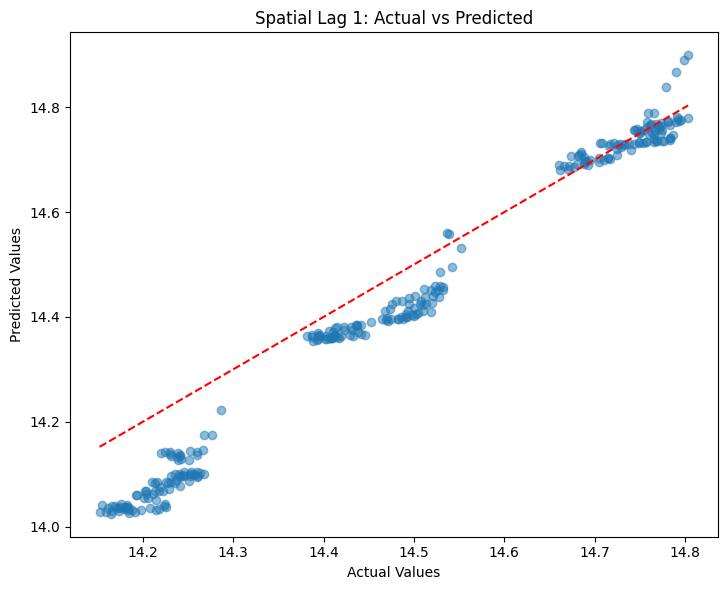

In [7]:
import matplotlib.pyplot as plt
# Predict on test set
y_pred_sr1 = ridge_sr1.predict(X_test_sr1)

# Plot Actual vs Predicted for Spatial Lag 1
plt.figure(figsize=(14, 6))

# Spatial Lag 1
plt.subplot(1, 2, 1)
plt.scatter(y_test_sr1, y_pred_sr1, alpha=0.5)
plt.plot([y_test_sr1.min(), y_test_sr1.max()], [y_test_sr1.min(), y_test_sr1.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Spatial Lag 1: Actual vs Predicted")
plt.tight_layout()
plt.savefig("actual_vs_predicted_spatial_lag1.png")
plt.show()

# Other SLR Models - Spatial Lag 1 (SLR1) (original features)

Best alpha: 0.0001
Test R²: 0.14992202765503448
Test RMSE: 0.20095496117982575

Top Influential Features:
                             Feature  Coefficient  Abs Coef
10                     smoothed_wcli     3.897497  3.897497
1            smoothed_wspent_time_1d    -0.708673  0.708673
9           smoothed_wlarge_event_1d     0.704033  0.704033
11       smoothed_wpublic_transit_1d    -0.679828  0.679828
12        smoothed_wcovid_vaccinated    -0.445106  0.445106
3       smoothed_wworried_become_ill     0.394160  0.394160
2               smoothed_wtested_14d    -0.337565  0.337565
8       smoothed_wvaccine_likely_who    -0.273876  0.273876
4                  smoothed_wshop_1d     0.267412  0.267412
13  smoothed_wvaccine_likely_friends     0.226119  0.226119


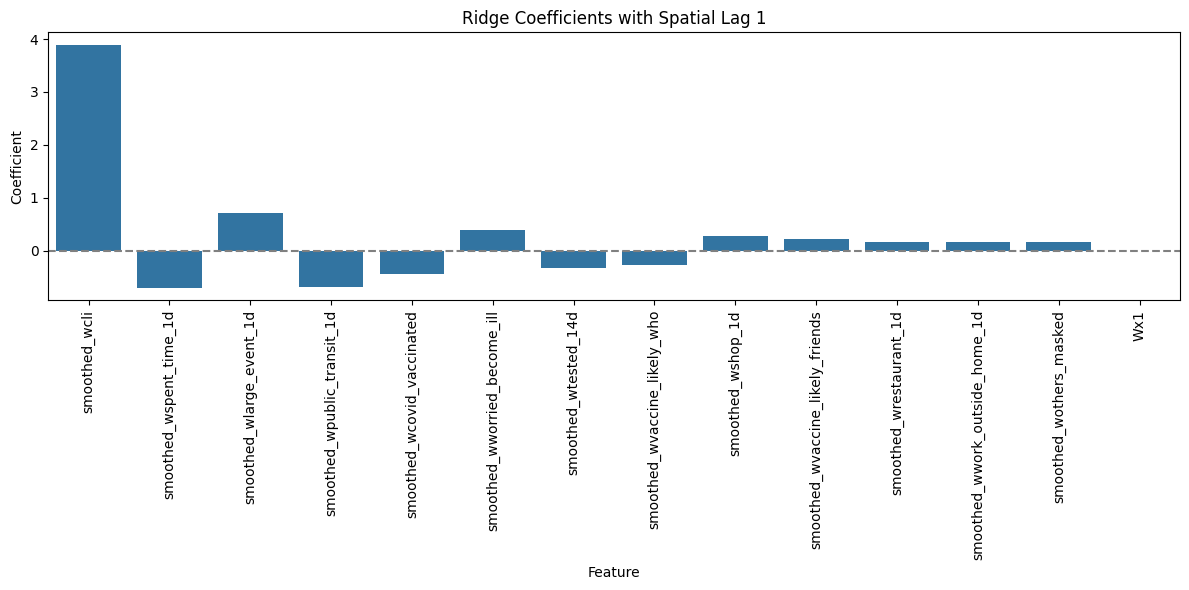

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('merged_fips_moving_average_data.csv')
# Drop one variable from each highly correlated pair
highly_corr_to_drop = [
    "smoothed_wvaccine_likely_govt_health",  # drop in favor of smoothed_wvaccine_likely_who
    "smoothed_wwearing_mask"                 # drop in favor of smoothed_wothers_masked
]

# Drop the columns
data = data.drop(columns=highly_corr_to_drop)

from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# --- Define target and features ---
target_col = "smoothed_wtested_positive_14d"

current_features = [
    'smoothed_wspent_time_1d',
    'smoothed_wtested_14d',       
    'smoothed_wworried_become_ill',
    'smoothed_wshop_1d',
    'smoothed_wwork_outside_home_1d',
    'smoothed_wothers_masked',
    'smoothed_wrestaurant_1d',
    'smoothed_wvaccine_likely_who',
    'smoothed_wlarge_event_1d',  
]

lagged_features_original = [
    'smoothed_wcli',
    'smoothed_wpublic_transit_1d',
    'smoothed_wcovid_vaccinated',
    'smoothed_wvaccine_likely_friends',
]

lagged_features = [
    'smoothed_wcli_lagged',
    'smoothed_wpublic_transit_1d_lagged',
    'smoothed_wcovid_vaccinated_lagged',
    'smoothed_wvaccine_likely_friends_lagged'
]

all_features = current_features + lagged_features_original

# Parse time_value as datetime
data['time_value'] = pd.to_datetime(data['time_value'])
# Sort chronologically
data = data.sort_values('time_value')

# Row indices for cutoff at 80%, 90%, and 100%
cutoff_80 = int(len(data) * 0.8)
cutoff_90 = int(len(data) * 0.9)
cutoff_100 = len(data)

# Cutoff dates
train_cutoff_date = data.loc[cutoff_80, 'time_value']
validation_cutoff_date = data.loc[cutoff_90, 'time_value']
test_cutoff_date = data.loc[cutoff_100 - 1, 'time_value']

# Temporal split
train_data = data[data['time_value'] < train_cutoff_date]
val_data = data[(data['time_value'] >= train_cutoff_date) & (data['time_value'] < validation_cutoff_date)]
test_data = data[data['time_value'] >= validation_cutoff_date]

# Sort by time and geo_value
train_data_sorted = train_data.sort_values(["geo_value", "time_value"]).reset_index(drop=True)
val_data_sorted = val_data.sort_values(["geo_value", "time_value"]).reset_index(drop=True)
test_data_sorted = test_data.sort_values(["geo_value", "time_value"]).reset_index(drop=True)

# Create lags
def create_lagged_target(df, col, max_lag):
    for lag in range(1, max_lag + 1):
        df[f"{target_col}_lag{lag}"] = (
            df.groupby("geo_value")[target_col]
            .shift(lag)
        )
    return df

train_data_sorted = create_lagged_target(train_data_sorted, target_col, max_lag=2)
val_data_sorted = create_lagged_target(val_data_sorted, target_col, max_lag=2)
test_data_sorted = create_lagged_target(test_data_sorted, target_col, max_lag=2)

# Drop rows with NaN values
train = train_data_sorted.dropna(subset=all_features + [target_col])
val = val_data_sorted.dropna(subset=all_features + [target_col])
test = test_data_sorted.dropna(subset=all_features + [target_col])

# Extract feature matrix and target
X = train[all_features]
y = train[target_col]

# Build a mapping from county to state
county_to_state = train_data_sorted.drop_duplicates("geo_value")[["geo_value", "FIPS State"]]

# Construct W: geo_value × geo_value binary matrix (1 if same state)
geo_values = train_data_sorted["geo_value"].unique()
geo_index = {g: i for i, g in enumerate(geo_values)}
N = len(geo_values)
W = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        if county_to_state.loc[county_to_state["geo_value"] == geo_values[i], "FIPS State"].values[0] == \
           county_to_state.loc[county_to_state["geo_value"] == geo_values[j], "FIPS State"].values[0]:
            W[i, j] = 1

# Row-normalize
W = W / W.sum(axis=1, keepdims=True)

# --- Feature matrix builder with spatial lags ---
def build_matrix_with_spatial_lags_sr1(df, geo_index, W, target_col, current_features, lagged_features_original):
    X_list = []
    y_list = []

    for date in df["time_value"].unique():
        df_t = df[df["time_value"] == date].copy()
        if df_t.shape[0] < 10:
            print(f"Date {date.date()} skipped, only {df_t.shape[0]} counties")
            continue

        df_t = df_t.set_index("geo_value")
        valid_geo = [g for g in df_t.index if g in geo_index]
        if not valid_geo:
            continue
        idx = [geo_index[g] for g in valid_geo]
        df_t = df_t.loc[valid_geo]

        W_sub = W[np.ix_(idx, idx)]

        # Spatial lag of target (lag1)
        x1 = df_t.loc[valid_geo, f"{target_col}_lag1"].values.reshape(-1, 1)
        Wx1 = W_sub @ x1

        # Feature matrix
        feats = df_t.loc[valid_geo, all_features].values
        X = np.hstack([Wx1, feats])
        y = df_t.loc[valid_geo, target_col].values

        X_list.append(X)
        y_list.append(y)

    if not X_list:
        raise ValueError("No valid time slices with spatial lag could be used.")
    
    return np.vstack(X_list), np.concatenate(y_list)

X_train_sr1, y_train_sr1 = build_matrix_with_spatial_lags_sr1(train_data_sorted, geo_index, W, target_col, current_features, lagged_features_original)
X_val_sr1, y_val_sr1 = build_matrix_with_spatial_lags_sr1(val_data_sorted, geo_index, W, target_col, current_features, lagged_features_original)
X_test_sr1, y_test_sr1 = build_matrix_with_spatial_lags_sr1(test_data_sorted, geo_index, W, target_col, current_features, lagged_features_original)

# Remove any rows with NaNs in training, validation, or test sets
def drop_nan_rows(X, y):
    mask = ~np.isnan(X).any(axis=1)
    return X[mask], y[mask]

X_train_sr1, y_train_sr1 = drop_nan_rows(X_train_sr1, y_train_sr1)
X_val_sr1, y_val_sr1 = drop_nan_rows(X_val_sr1, y_val_sr1)
X_test_sr1, y_test_sr1 = drop_nan_rows(X_test_sr1, y_test_sr1)

# --- Ridge Regression with 5-Fold CV ---
alphas = np.logspace(-4, 4, 20)
ridge_sr1 = RidgeCV(alphas=alphas, cv=KFold(n_splits=5, shuffle=True, random_state=42))
ridge_sr1.fit(X_train_sr1, y_train_sr1)

# --- Evaluation ---
y_pred_sr1 = ridge_sr1.predict(X_test_sr1)
print("Best alpha:", ridge_sr1.alpha_)
print("Test R²:", r2_score(y_test_sr1, y_pred_sr1))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test_sr1, y_pred_sr1)))

# --- Coefficients and Feature Mapping ---
all_feature_names = ['Wx1'] + current_features + lagged_features_original
coef_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Coefficient": ridge_sr1.coef_,
    "Abs Coef": np.abs(ridge_sr1.coef_)
}).sort_values("Abs Coef", ascending=False)

print("\nTop Influential Features:")
print(coef_df.head(10))

# Plot coefficients ---
plt.figure(figsize=(12, 6))
sns.barplot(data=coef_df, x="Feature", y="Coefficient")
plt.xticks(rotation=90)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Ridge Coefficients with Spatial Lag 1")
plt.tight_layout()
plt.show()

# Other SLR Models - Spatial Lag Regression 2 (SLR2)

Best alpha: 0.0018329807108324356
Test R²: 0.488742411941654
Test RMSE: 0.03500186106029857

Top Influential Features:
                                    Feature  Coefficient  Abs Coef
12       smoothed_wpublic_transit_1d_lagged    -0.773182  0.773182
11                     smoothed_wcli_lagged     0.751734  0.751734
13        smoothed_wcovid_vaccinated_lagged    -0.375469  0.375469
4              smoothed_wworried_become_ill     0.356605  0.356605
6            smoothed_wwork_outside_home_1d     0.321860  0.321860
2                   smoothed_wspent_time_1d    -0.261116  0.261116
10                 smoothed_wlarge_event_1d    -0.233944  0.233944
9              smoothed_wvaccine_likely_who    -0.198793  0.198793
8                   smoothed_wrestaurant_1d     0.135054  0.135054
14  smoothed_wvaccine_likely_friends_lagged    -0.125096  0.125096


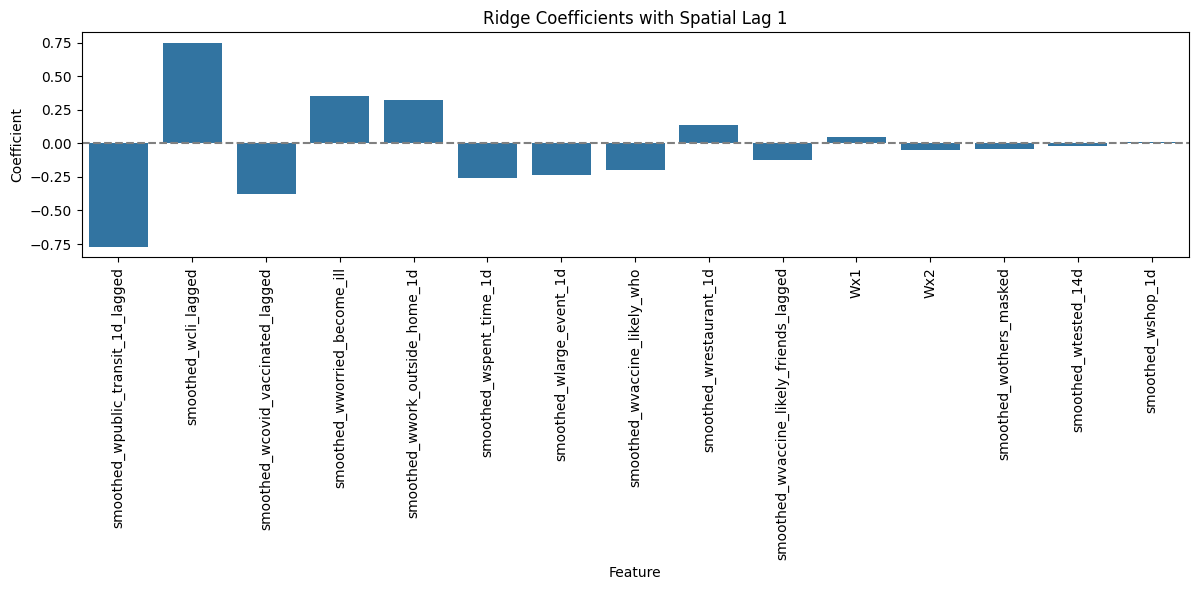

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('merged_fips_moving_average_data.csv')
# Drop one variable from each highly correlated pair
highly_corr_to_drop = [
    "smoothed_wvaccine_likely_govt_health",  # drop in favor of smoothed_wvaccine_likely_who
    "smoothed_wwearing_mask"                 # drop in favor of smoothed_wothers_masked
]

# Drop the columns
data = data.drop(columns=highly_corr_to_drop)

from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# --- Define target and features ---
target_col = "smoothed_wtested_positive_14d"

current_features = [
    'smoothed_wspent_time_1d',
    'smoothed_wtested_14d',       
    'smoothed_wworried_become_ill',
    'smoothed_wshop_1d',
    'smoothed_wwork_outside_home_1d',
    'smoothed_wothers_masked',
    'smoothed_wrestaurant_1d',
    'smoothed_wvaccine_likely_who',
    'smoothed_wlarge_event_1d',  
]

lagged_features_original = [
    'smoothed_wcli',
    'smoothed_wpublic_transit_1d',
    'smoothed_wcovid_vaccinated',
    'smoothed_wvaccine_likely_friends',
]

lagged_features = [
    'smoothed_wcli_lagged',
    'smoothed_wpublic_transit_1d_lagged',
    'smoothed_wcovid_vaccinated_lagged',
    'smoothed_wvaccine_likely_friends_lagged'
]

all_features = current_features + lagged_features

# Parse time_value as datetime
data['time_value'] = pd.to_datetime(data['time_value'])
# Sort chronologically
data = data.sort_values('time_value')

# Row indices for cutoff at 80%, 90%, and 100%
cutoff_80 = int(len(data) * 0.8)
cutoff_90 = int(len(data) * 0.9)
cutoff_100 = len(data)

# Cutoff dates
train_cutoff_date = data.loc[cutoff_80, 'time_value']
validation_cutoff_date = data.loc[cutoff_90, 'time_value']
test_cutoff_date = data.loc[cutoff_100 - 1, 'time_value']

# Temporal split
train_data = data[data['time_value'] < train_cutoff_date]
val_data = data[(data['time_value'] >= train_cutoff_date) & (data['time_value'] < validation_cutoff_date)]
test_data = data[data['time_value'] >= validation_cutoff_date]

# Sort by time and geo_value
train_data_sorted = train_data.sort_values(["geo_value", "time_value"]).reset_index(drop=True)
val_data_sorted = val_data.sort_values(["geo_value", "time_value"]).reset_index(drop=True)
test_data_sorted = test_data.sort_values(["geo_value", "time_value"]).reset_index(drop=True)

# Create lags
def create_lagged_target(df, col, max_lag):
    for lag in range(1, max_lag + 1):
        df[f"{target_col}_lag{lag}"] = (
            df.groupby("geo_value")[target_col]
            .shift(lag)
        )
    return df

train_data_sorted = create_lagged_target(train_data_sorted, target_col, max_lag=2)
val_data_sorted = create_lagged_target(val_data_sorted, target_col, max_lag=2)
test_data_sorted = create_lagged_target(test_data_sorted, target_col, max_lag=2)

# Drop rows with NaN values
train = train_data_sorted.dropna(subset=all_features + [target_col])
val = val_data_sorted.dropna(subset=all_features + [target_col])
test = test_data_sorted.dropna(subset=all_features + [target_col])

# Extract feature matrix and target
X = train[all_features]
y = train[target_col]

# Build a mapping from county to state
county_to_state = train_data_sorted.drop_duplicates("geo_value")[["geo_value", "FIPS State"]]

# Construct W: geo_value × geo_value binary matrix (1 if same state)
geo_values = train_data_sorted["geo_value"].unique()
geo_index = {g: i for i, g in enumerate(geo_values)}
N = len(geo_values)
W = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        if county_to_state.loc[county_to_state["geo_value"] == geo_values[i], "FIPS State"].values[0] == \
           county_to_state.loc[county_to_state["geo_value"] == geo_values[j], "FIPS State"].values[0]:
            W[i, j] = 1

# Row-normalize
W = W / W.sum(axis=1, keepdims=True)

# --- Feature matrix builder with spatial lags ---

def build_matrix_with_spatial_lags_sr2(df, geo_index, W, target_col, current_features, lagged_features):
    X_list = []
    y_list = []

    for date in df["time_value"].unique():
        df_t = df[df["time_value"] == date].copy()
        if df_t.shape[0] < 10:
            print(f"Date {date.date()} skipped, only {df_t.shape[0]} counties")
            continue

        df_t = df_t.set_index("geo_value")
        valid_geo = [g for g in df_t.index if g in geo_index]
        if not valid_geo:
            continue
        idx = [geo_index[g] for g in valid_geo]
        df_t = df_t.loc[valid_geo]

        W_sub = W[np.ix_(idx, idx)]

        # Spatial lags
        x1 = df_t.loc[valid_geo, f"{target_col}_lag1"].values.reshape(-1, 1)
        x2 = df_t.loc[valid_geo, f"{target_col}_lag2"].values.reshape(-1, 1)
        Wx1 = W_sub @ x1
        Wx2 = W_sub @ x2

        # Feature matrix
        feats = df_t.loc[valid_geo, current_features + lagged_features].values
        X = np.hstack([Wx1, Wx2, feats])
        y = df_t.loc[valid_geo, target_col].values

        X_list.append(X)
        y_list.append(y)

    if not X_list:
        raise ValueError("No valid time slices with spatial lag could be used.")
    
    return np.vstack(X_list), np.concatenate(y_list)

X_train_sr2, y_train_sr2 = build_matrix_with_spatial_lags_sr2(train_data_sorted, geo_index, W, target_col, current_features, lagged_features)
X_val_sr2, y_val_sr2 = build_matrix_with_spatial_lags_sr2(val_data_sorted, geo_index, W, target_col, current_features, lagged_features)
X_test_sr2, y_test_sr2 = build_matrix_with_spatial_lags_sr2(test_data_sorted, geo_index, W, target_col, current_features, lagged_features)

# Remove any rows with NaNs in training, validation, or test sets
def drop_nan_rows(X, y):
    mask = ~np.isnan(X).any(axis=1)
    return X[mask], y[mask]

X_train_sr2, y_train_sr2 = drop_nan_rows(X_train_sr2, y_train_sr2)
X_val_sr2, y_val_sr2 = drop_nan_rows(X_val_sr2, y_val_sr2)
X_test_sr2, y_test_sr2 = drop_nan_rows(X_test_sr2, y_test_sr2)

# --- Ridge Regression with 5-Fold CV ---
alphas = np.logspace(-4, 4, 20)
ridge_sr2 = RidgeCV(alphas=alphas, cv=KFold(n_splits=5, shuffle=True, random_state=42))
ridge_sr2.fit(X_train_sr2, y_train_sr2)

# --- Evaluation ---
y_pred_sr2 = ridge_sr2.predict(X_test_sr2)
print("Best alpha:", ridge_sr2.alpha_)
print("Test R²:", r2_score(y_test_sr2, y_pred_sr2))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test_sr2, y_pred_sr2)))

# --- Coefficients and Feature Mapping ---
all_feature_names = ['Wx1', 'Wx2'] + current_features + lagged_features
coef_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Coefficient": ridge_sr2.coef_,
    "Abs Coef": np.abs(ridge_sr2.coef_)
}).sort_values("Abs Coef", ascending=False)

print("\nTop Influential Features:")
print(coef_df.head(10))

# Plot coefficients ---
plt.figure(figsize=(12, 6))
sns.barplot(data=coef_df, x="Feature", y="Coefficient")
plt.xticks(rotation=90)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Ridge Coefficients with Spatial Lag 1")
plt.tight_layout()
plt.show()

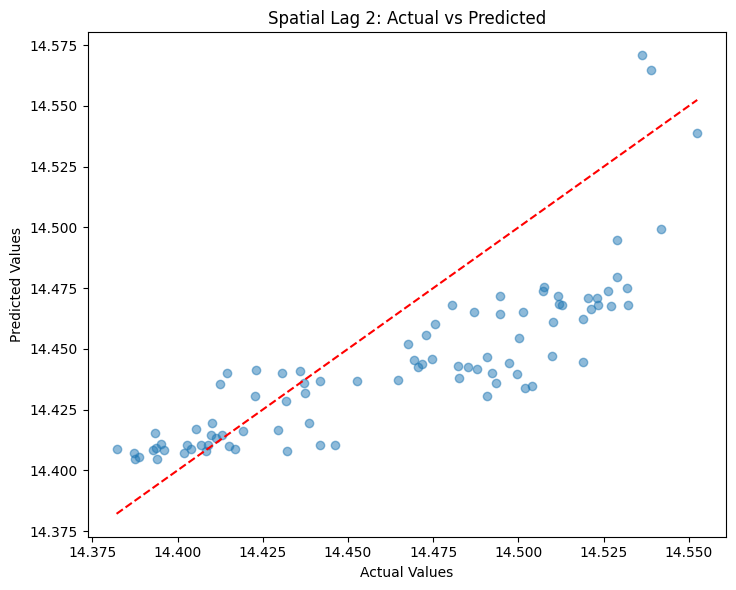

In [10]:
import matplotlib.pyplot as plt

# Plot Actual vs Predicted for Spatial Lag 1 and Spatial Lag 2
plt.figure(figsize=(14, 6))
# Spatial Lag 2
plt.subplot(1, 2, 2)
plt.scatter(y_test_sr2, y_pred_sr2, alpha=0.5)
plt.plot([y_test_sr2.min(), y_test_sr2.max()], [y_test_sr2.min(), y_test_sr2.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Spatial Lag 2: Actual vs Predicted")
plt.tight_layout()
plt.show()